In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio
from rasterstats import point_query, zonal_stats
from rasterio.mask import mask
import subprocess
from osgeo import gdal
import warnings
warnings.filterwarnings("ignore")
print("BE CAREFULL warning are masked !!")

BE CAREFULL warning are masked !!


In [2]:
EnMAP_im_file = 'images/masked_image.tif'
S2_path = 'images/Stack_im.tif'
S2_mask_path = 'images/SENTINEL2A_20230415-105655-486_L2A_T31UES_C_V1-0_CLM_R1.tif'

mask_ref = 'images/ref_mask.tif' ## mask (containing only ones, to be used as reference)

shp_path = 'images/DECL_23_crop.shp'

Creating a new global mask for S2 and EnMAP data

In [9]:
### path of global extent images

mask_S2_glob_path = 'images/mask_S2_resampled_glob.tif'

EnMAP_glob_path = 'images/EnMAP_resampled_glob.tif'

S2_glob_path = 'images/Stack_im_resampled_glob.tif'



S2

In [6]:
mask_ref_S2_mask = 'images/out/1.tif'


# Read the reference mask to get the extent (transform) and CRS
src = rasterio.open(S2_glob_path, "r")
array = src.read(4)
array = array.astype(float)

src_cloud = rasterio.open(mask_S2_glob_path, "r")
CLOUD_MASK = src_cloud.read(1)
CLOUD_MASK = CLOUD_MASK.astype(float)
src_cloud.close()

# set values for any form of cloud to nan

CLOUD_MASK[CLOUD_MASK > 0] = 1000000


# open the image and extract array

# Update metadata

profile = src.profile
profile.update(dtype=rasterio.int16,  # Set to int16 it is lighter than float
        nodata=-32768.0,     # Set nodata value in metadata
        compress='lzw',)


src.close()

# Mask image reflectances with the cloud mask
im_masked = array + CLOUD_MASK

im_masked[im_masked > 1000000] = 0

im_masked[im_masked > 0] = 1

#im_masked[np.isnan(im_masked)] = -32768.0

# Change the array's type : from float to integer 16
im_masked = im_masked.astype(np.int16)

# Write image

if im_masked.ndim > 2:
    im_masked = np.squeeze(im_masked)  # Remove extra dimensions

# Write image
dst = rasterio.open(mask_ref_S2_mask, 'w+', **profile)
dst.write(im_masked, 1)  # Write array to band 1
dst.close()


EnMap

In [11]:
mask_interm_2 = 'images/out/2.tif'


# Read the reference mask to get the extent (transform) and CRS
src = rasterio.open(EnMAP_glob_path, "r")
array = src.read(4)
array = array.astype(int)


src_cloud = rasterio.open(mask_ref_S2_mask, "r")
CLOUD_MASK = src_cloud.read(1)
CLOUD_MASK = CLOUD_MASK.astype(int)
src_cloud.close()



profile = src.profile
profile.update(dtype=rasterio.int16,  # Set to int16 it is lighter than float
        nodata=-32768.0,     # Set nodata value in metadata
        compress='lzw',)


src.close()

# Mask image reflectances with the cloud mask
im_masked = array * CLOUD_MASK

im_masked[im_masked != 0] =1


#im_masked[np.isnan(im_masked)] = -32768.0

# Change the array's type : from float to integer 16
im_masked = im_masked.astype(np.int16)

# Write image

if im_masked.ndim > 2:
    im_masked = np.squeeze(im_masked)  # Remove extra dimensions

# Write image
dst = rasterio.open(mask_interm_2, 'w+', **profile)
dst.write(im_masked, 1)  # Write array to band 1
dst.close()



Mask NDVI EnMAP

In [12]:
mask_interm_3 = 'images/out/3.tif'


src_cloud = rasterio.open(mask_interm_2, "r")
CLOUD_MASK = src_cloud.read(1)
CLOUD_MASK = CLOUD_MASK.astype(int)
src_cloud.close()


src = rasterio.open(EnMAP_glob_path, "r")
profile = src.profile
profile.update(dtype=rasterio.float32, 
               count = 1, 
               compress = 'lzw')

red_arr = src.read(44)

nir_arr = src.read(108)

NDVI_arr = ((nir_arr - red_arr)/(nir_arr+red_arr))

NDVI_arr[NDVI_arr < 0.4]  = 0

NDVI_arr[np.where(np.isnan(NDVI_arr))] = 0

new_mask = CLOUD_MASK * NDVI_arr

new_mask[new_mask > 0] = 1

src.close()

dst = rasterio.open(mask_interm_3, 'w+', **profile)
dst.write(new_mask, 1)  # Write array to band 1
dst.close()


Mask NDVI S2

In [13]:
mask_interm_4 = 'images/out/4.tif'


src_cloud = rasterio.open(mask_interm_3, "r")
CLOUD_MASK = src_cloud.read(1)
CLOUD_MASK = CLOUD_MASK.astype(int)
src_cloud.close()


src = rasterio.open(S2_glob_path, "r")
profile = src.profile
profile.update(dtype=rasterio.float32, 
               count = 1, 
               compress = 'lzw')

red_arr = src.read(3)

nir_arr = src.read(7)

NDVI_arr = ((nir_arr - red_arr)/(nir_arr+red_arr))

NDVI_arr[NDVI_arr < 0.4]  = 0

NDVI_arr[np.where(np.isnan(NDVI_arr))] = 0

new_mask = CLOUD_MASK * NDVI_arr

new_mask[new_mask > 0] = 1

src.close()

dst = rasterio.open(mask_interm_4, 'w+', **profile)
dst.write(new_mask, 1)  # Write array to band 1
dst.close()

EnMAP

In [15]:
src = rasterio.open(mask_interm_4, "r")
CLOUD_MASK = src.read(1)
CLOUD_MASK = CLOUD_MASK.astype(float)
src.close()

# open the image and extract array

src = rasterio.open(EnMAP_glob_path, "r")
im = src.read()

# Update metadata

profile = src.profile
profile.update(dtype=rasterio.int16,  # Set to int16 it is lighter than float
nodata=-32768.0,     # Set nodata value in metadata
compress='lzw') 

# Mask image reflectances with the cloud mask
im_masked = im * CLOUD_MASK


im_masked[np.isnan(im_masked)] = -32768.0

# Change the array's type : from float to integer 16
im_masked = im_masked.astype(np.int16)

# Write image
dst = rasterio.open('images/out/EnMAP_glob_masked.tif', 'w', **profile)
for i in range(224):
    dst.write(im_masked[i], i + 1)  # i + 1 is the band index


# Close rasterio objects
src.close()
dst.close()


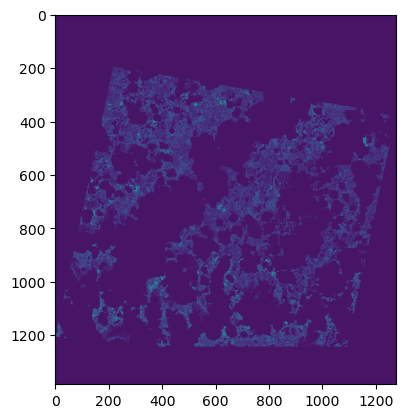

In [16]:
import matplotlib.pyplot as plt
with rasterio.open('images/out/EnMAP_glob_masked.tif') as src:
    data =src.read(15)

fig = plt.figure()
ax1 = fig.add_subplot()
im1 = ax1.imshow(data)

S2

In [17]:
src = rasterio.open(mask_interm_4, "r")
CLOUD_MASK = src.read(1)
CLOUD_MASK = CLOUD_MASK.astype(float)
src.close()

# set values for any form of cloud to nan


# open the image and extract array

src = rasterio.open(S2_glob_path, "r")
im = src.read()

# Update metadata

profile = src.profile
profile.update(dtype=rasterio.int16,  # Set to int16 it is lighter than float
nodata=-32768.0,     # Set nodata value in metadata
compress='lzw') 

# Mask image reflectances with the cloud mask
im_masked = im * CLOUD_MASK


im_masked[np.isnan(im_masked)] = -32768.0

# Change the array's type : from float to integer 16
im_masked = im_masked.astype(np.int16)

# Write image
dst = rasterio.open('images/out/S2_glob_masked.tif', 'w', **profile)
for i in range(10):
    dst.write(im_masked[i], i + 1)  # i + 1 is the band index


# Close rasterio objects
src.close()
dst.close()

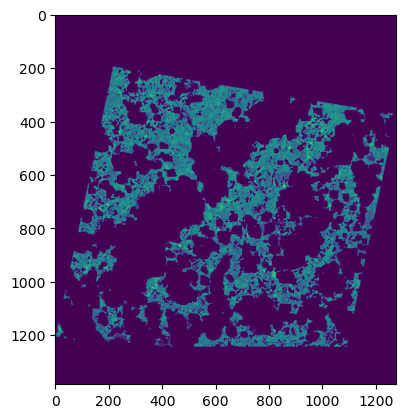

In [19]:
import matplotlib.pyplot as plt
with rasterio.open('images/out/S2_glob_masked.tif') as src:
    data =src.read(4)

fig = plt.figure()
ax1 = fig.add_subplot()
im1 = ax1.imshow(data)